In [296]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)
from sklearn import metrics
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
# To tune different models
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    
    roc_auc_score,
    make_scorer,
   
    precision_recall_curve,
    roc_curve,
)

In [297]:
airlines= pd.read_csv ('airlines.csv')
weather= pd.read_csv ('weather.csv')
planes= pd.read_csv ('planes.csv')
airports= pd.read_csv ('airports.csv')
flights= pd.read_csv ('flights.csv')

In [298]:
airlines.head()

,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.
2,AS,Alaska Airlines Inc.
3,B6,JetBlue Airways
4,DL,Delta Air Lines Inc.


### Preprocessing Steps

#### Handling missing values

In [299]:
planes.isna().mean()*100
planes['year'].fillna(planes['year'].mean(),inplace=True)
flights.dropna(inplace = True)

In [300]:
weather['pressure']=weather.groupby(['year','month','day','origin'])['pressure'].transform(lambda x: x.fillna(x.mean()))
weather['temp']=weather.groupby(['year','month','day','origin'])['temp'].transform(lambda x: x.fillna(x.mean()))
weather['humid']=weather.groupby(['year','month','day','origin'])['humid'].transform(lambda x: x.fillna(x.mean()))
weather['dewp']=weather.groupby(['year','month','day','origin'])['dewp'].transform(lambda x: x.fillna(x.mean()))
weather['wind_speed']=weather.groupby(['year','month','day','origin'])['wind_speed'].transform(lambda x: x.fillna(x.mean()))
weather['wind_dir']=weather.groupby(['year','month','day','origin'])['wind_dir'].transform(lambda x: x.fillna(x.mean()))

In [301]:
weather=weather.drop(columns=['wind_gust'])

In [302]:
flights.isna().mean()*100

year              0.0
month             0.0
day               0.0
dep_time          0.0
sched_dep_time    0.0
dep_delay         0.0
arr_time          0.0
sched_arr_time    0.0
arr_delay         0.0
carrier           0.0
flight            0.0
tailnum           0.0
origin            0.0
dest              0.0
air_time          0.0
distance          0.0
hour              0.0
minute            0.0
time_hour         0.0
dtype: float64

In [303]:
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T10:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T10:00:00Z
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01T10:00:00Z
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01T10:00:00Z
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01T11:00:00Z


### EDA

In [304]:
abbr_companies = airlines.set_index('carrier')['name'].to_dict()

In [305]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = flights['dep_delay'].groupby(flights['carrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
carrier,,,,
OO,-14.0,154.0,29.0,12.586207
HA,-16.0,1301.0,342.0,4.900585
YV,-16.0,387.0,544.0,18.898897
F9,-27.0,853.0,681.0,20.201175
AS,-21.0,225.0,709.0,5.830748
FL,-22.0,602.0,3175.0,18.605984
VX,-20.0,653.0,5116.0,12.756646
WN,-13.0,471.0,12044.0,17.661657
9E,-24.0,747.0,17294.0,16.439574


FixedFormatter should only be used together with FixedLocator


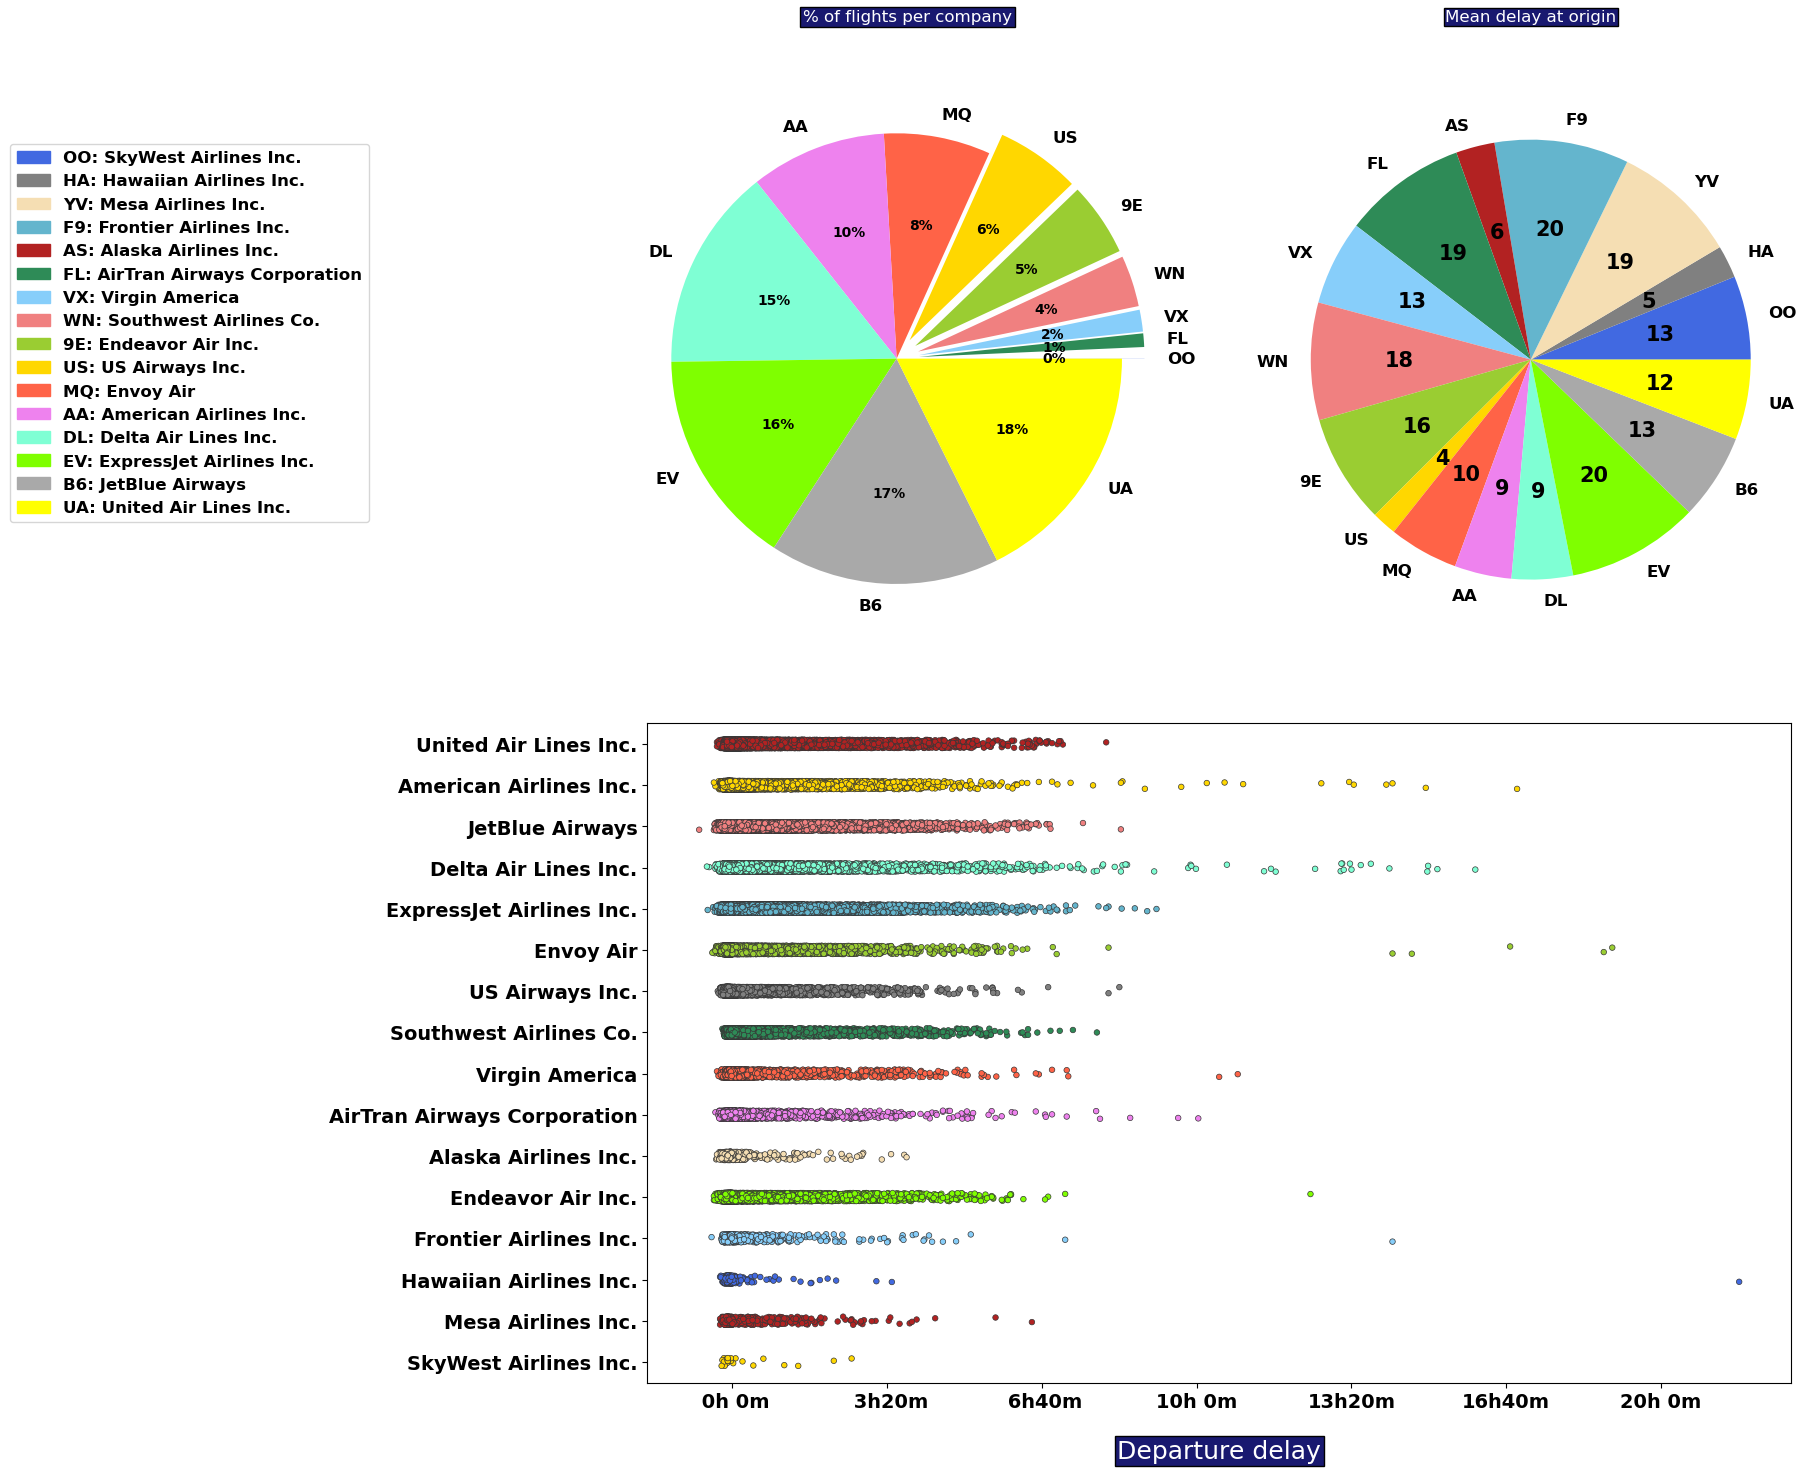

In [306]:
import matplotlib as mpl
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = flights.loc[:, ['carrier', 'dep_delay']]
df2['carrier'] = df2['carrier'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse', 'darkgrey', 'yellow']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.1 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0,textprops={'fontsize':10})

patches[1].set_visible(False)
texts[1].set_visible(False)
autotexts[1].set_visible(False)

patches[2].set_visible(False)
texts[2].set_visible(False)
autotexts[2].set_visible(False)

patches[3].set_visible(False)
texts[3].set_visible(False)
autotexts[3].set_visible(False)
patches[4].set_visible(False)
texts[4].set_visible(False)
autotexts[4].set_visible(False)


for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(12)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':2},
              color = 'w',fontsize=12)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.1, 0.9), 
           fontsize = 12, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(12)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':1},
              color='w', fontsize=12)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey', 'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="carrier", x="dep_delay", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':2},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
plt.tight_layout(w_pad=3) 

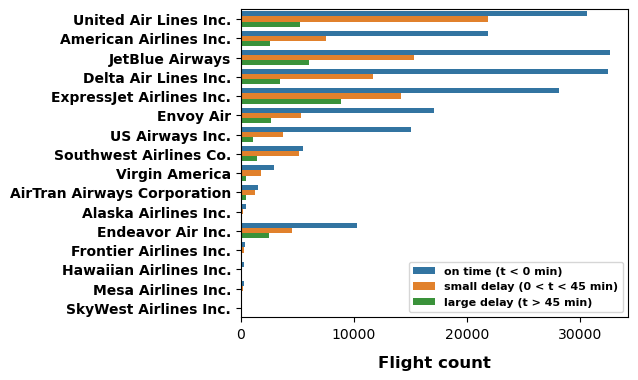

In [307]:
#_____________________________________________
# Function that define how delays are grouped
df_flights=flights.copy()
delay_type = lambda x:((0,1)[x > 0],2)[x > 45]
df_flights['DELAY_LEVEL'] = df_flights['dep_delay'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(5,4))
ax = sns.countplot(y="carrier", hue='DELAY_LEVEL', data=df_flights)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=10, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=10, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=12, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend(loc='lower right',fontsize = 8)
L.get_texts()[0].set_text('on time (t < 0 min)')
L.get_texts()[1].set_text('small delay (0 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

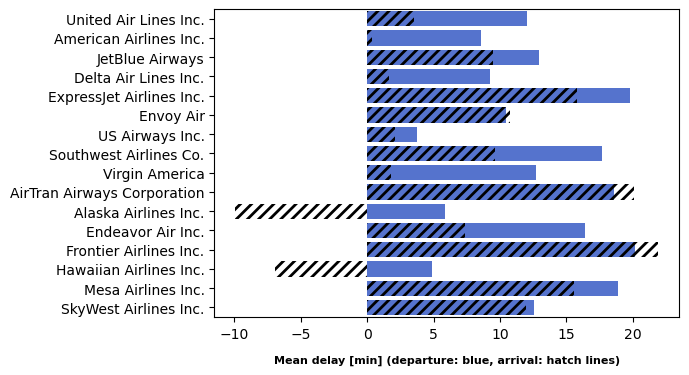

In [308]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(6,4))
ax = sns.barplot(x="dep_delay", y="carrier", data=flights, color="royalblue", ci=None)
ax = sns.barplot(x="arr_delay", y="carrier", data=flights, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (departure: blue, arrival: hatch lines)',fontsize=8, weight = 'bold', labelpad=10);

In [309]:
from scipy.stats.stats import pearsonr
flight_distance=flights['distance']
arrival_delay=flights['arr_delay']
#calculation correlation coefficient and p-value between x and y

correlation, p_value = pearsonr(flight_distance, arrival_delay)

# Print the correlation coefficient and p-value
print("Pearson Correlation Coefficient:", correlation)
print("P-value:", p_value)

Pearson Correlation Coefficient: -0.061867756088787244
P-value: 5.7062979472445125e-275


In [310]:
planes.head()

,tailnum,year,type,manufacturer,model,engines,seats,engine
0,N10156,2004.0,Fixed wing multi engine,embraer,EMB-145XR,2,55,Turbo-fan
1,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,Turbo-fan
2,N103US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,Turbo-fan
3,N104UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,Turbo-fan
4,N10575,2002.0,Fixed wing multi engine,embraer,EMB-145LR,2,55,Turbo-fan


In [311]:
planes = planes.replace({'manufacturer' : { 'BOEING' : 'boeing', 
                                    'AIRBUS INDUSTRIE' : 'airbus', 'AIRBUS' : 'airbus', 'airbus industrie' : 'airbus',
                                    'mcdonnell douglas aircraft co' : 'mcdonnell douglas', 'mcdonnell douglas corporation' : 'mcdonnell douglas',
                                    'MCDONNELL DOUGLAS' : 'mcdonnell douglas','douglas':'mcdonnell douglas', 'canadair ltd' : 'Other',
                                    'canadair':'Other',
                                    'john g hess' : 'Other', 'avions marcel dassault' : 'Other', 'hurley james larry' : 'Other',
                                    'aviat aircraft inc' : 'Other', 'learjet inc' : 'Other', 'douglas' : 'Other', 'hurley' : 'Other', 
                                    'pair mike e' : 'Other', 'sikorsky' : 'Other', 'agusta spa' : 'Other', 'leblanc glenn t' : 'Other',
                                    'american aircraft inc' : 'Other', 'marz barry' : 'Other', 'sikorsky' : 'Other', 'beech' : 'Other',
                                    'kildall gary' : 'Other', 'stewart maco' : 'Other', 'lambert richard' : 'Other', 'friedemann jon' : 'Other',
                                    'dehavilland' : 'Other',  'bell' : 'Other', 'piper' : 'Other', 'barker jack l' : 'Other', 
                                    'robinson helicopter co' : 'Other', 'cirrus design corp' : 'Other', 'gulfstream aerospace' : 'Other', 
                                    'cessna' : 'Other'}
                    
                             })

In [312]:
flights['date'] = pd.to_datetime(flights[['day','month','year']])
flights['Day'] = flights['date'].dt.strftime('%A')
flights.head()
flights['Arr_delay?'] = np.where(flights['arr_delay'] > 0, 1, 0)
flights['Dept_delay?'] = np.where(flights['dep_delay'] > 0, 1, 0)

# flights['Dept_late_and_reached_on_time'] = np.where(((flights['dep_delay'] > 0) & (flights['arr_delay'] <= 0)), 1, 0)

# flights['Dept_late_and_arrived_late'] = np.where(((flights['dep_delay'] > 0) & (flights['arr_delay'] > 0)), 1, 0)
# flights['Flights_departed_on_time_but_arrived_late'] = np.where(((flights['dep_delay'] <= 0) & (flights['arr_delay'] > 0)), 1, 0)



In [313]:
conditions = [
    (flights['hour'] > 4) & (flights['hour'] <= 8),
    (flights['hour'] > 8) & (flights['hour'] <= 12),
    (flights['hour'] > 12) & (flights['hour'] <= 16),
    (flights['hour'] > 16) & (flights['hour'] <= 20),
    (flights['hour'] > 20) & (flights['hour'] <= 24),
    (flights['hour'] <= 4)    
    ]
results = ['Early Morning', 'Morning', 'Noon', 'Eve', 'Night', 'Late Night']

flights['time_of_day'] = np.select(conditions, results)

conditions = [
    flights['month'].isin([3,4,5]),
    flights['month'].isin([6,7,8]),
    flights['month'].isin([9,10,11]),
    flights['month'].isin([12,1,2])
    ]
results = ['Spring', 'Summer', 'Fall', 'Winter']


flights['season'] = np.select(conditions, results)

conditions = [
    flights['Day'].isin(['Saturday', 'Sunday']),
    1==1
    ]

results = [1, 0]


flights['weekend'] = np.select(conditions, results)
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,hour,minute,time_hour,date,Day,Arr_delay?,Dept_delay?,time_of_day,season,weekend
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,5,15,2013-01-01T10:00:00Z,2013-01-01,Tuesday,1,1,Early Morning,Winter,0
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,5,29,2013-01-01T10:00:00Z,2013-01-01,Tuesday,1,1,Early Morning,Winter,0
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,5,40,2013-01-01T10:00:00Z,2013-01-01,Tuesday,1,1,Early Morning,Winter,0
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,5,45,2013-01-01T10:00:00Z,2013-01-01,Tuesday,0,0,Early Morning,Winter,0
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,6,0,2013-01-01T11:00:00Z,2013-01-01,Tuesday,0,0,Early Morning,Winter,0


In [314]:
print('Airlines - ',list(airlines.columns))
print('Planes - ',list(planes.columns))
print('Weather - ',list(weather.columns))
print('Flights - ',list(flights.columns))
print('Airports - ',list(airports.columns))

Airlines -  ['carrier', 'name']
Planes -  ['tailnum', 'year', 'type', 'manufacturer', 'model', 'engines', 'seats', 'engine']
Weather -  ['origin', 'year', 'month', 'day', 'hour', 'temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'precip', 'pressure', 'visib', 'time_hour']
Flights -  ['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight', 'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute', 'time_hour', 'date', 'Day', 'Arr_delay?', 'Dept_delay?', 'time_of_day', 'season', 'weekend']
Airports -  ['faa', 'name', 'lat', 'lon', 'alt', 'tz', 'tzone']


In [315]:
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,hour,minute,time_hour,date,Day,Arr_delay?,Dept_delay?,time_of_day,season,weekend
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,5,15,2013-01-01T10:00:00Z,2013-01-01,Tuesday,1,1,Early Morning,Winter,0
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,5,29,2013-01-01T10:00:00Z,2013-01-01,Tuesday,1,1,Early Morning,Winter,0
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,5,40,2013-01-01T10:00:00Z,2013-01-01,Tuesday,1,1,Early Morning,Winter,0
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,5,45,2013-01-01T10:00:00Z,2013-01-01,Tuesday,0,0,Early Morning,Winter,0
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,6,0,2013-01-01T11:00:00Z,2013-01-01,Tuesday,0,0,Early Morning,Winter,0


In [316]:
df_weather_flight = pd.merge(flights, weather,on=['year', 'month', 'day','hour','origin'], how='left') 
df= pd.merge(df_weather_flight, airports, left_on='dest',right_on='faa',how='inner')
df = pd.merge(df, planes, on = ['tailnum'])

In [317]:
df = df.rename(columns={'year_x': 'year'})

In [318]:
df['pressure']=df.groupby(['year','month','day','origin'])['pressure'].transform(lambda x: x.fillna(x.mean()))
df['temp']=df.groupby(['year','month','day','origin'])['temp'].transform(lambda x: x.fillna(x.mean()))
df['humid']=df.groupby(['year','month','day','origin'])['humid'].transform(lambda x: x.fillna(x.mean()))
df['dewp']=df.groupby(['year','month','day','origin'])['dewp'].transform(lambda x: x.fillna(x.mean()))
df['wind_speed']=df.groupby(['year','month','day','origin'])['wind_speed'].transform(lambda x: x.fillna(x.mean()))
df['wind_dir']=df.groupby(['year','month','day','origin'])['wind_dir'].transform(lambda x: x.fillna(x.mean()))
df['precip']=df.groupby(['year','month','day','origin'])['precip'].transform(lambda x: x.fillna(x.mean()))
df['visib']=df.groupby(['year','month','day','origin'])['visib'].transform(lambda x: x.fillna(x.mean()))

In [319]:
# df.isna().mean()*100

In [320]:
df.columns

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour_x', 'date', 'Day', 'Arr_delay?', 'Dept_delay?',
       'time_of_day', 'season', 'weekend', 'temp', 'dewp', 'humid', 'wind_dir',
       'wind_speed', 'precip', 'pressure', 'visib', 'time_hour_y', 'faa',
       'name', 'lat', 'lon', 'alt', 'tz', 'tzone', 'year_y', 'type',
       'manufacturer', 'model', 'engines', 'seats', 'engine'],
      dtype='object')

### EDA

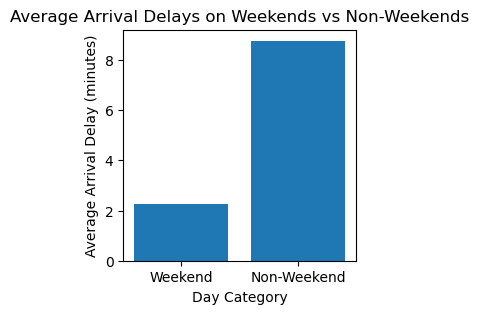

In [321]:
import matplotlib.pyplot as plt

# Example data
arrival_delays_weekend = df[df['weekend']==1]['arr_delay']  # Arrival delays on weekends
arrival_delays_non_weekend =df[df['weekend']==0]['arr_delay'] # Arrival delays on non-weekends
plt.figure(figsize=(3, 3)) 
# Create a bar plot
plt.bar(['Weekend', 'Non-Weekend'], [sum(arrival_delays_weekend)/len(arrival_delays_weekend),
                                     sum(arrival_delays_non_weekend)/len(arrival_delays_non_weekend)])

# Add labels and title
plt.xlabel('Day Category')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delays on Weekends vs Non-Weekends')

# Display the plot
plt.show()






In [322]:
weekend_mean_arr_delay=df[df['weekend']==1]['arr_delay'].mean()
print("The mean arrival delay on weekend is:", weekend_mean_arr_delay)

The mean arrival delay on weekend is: 2.27480816751203


In [323]:
weekday_mean_arr_delay=df[df['weekend']==0]['arr_delay'].mean()
print("The mean arrival delay on weekdays is:", weekday_mean_arr_delay)

The mean arrival delay on weekdays is: 8.762585371362357


In [324]:
import scipy.stats as stats

# Example data
arrival_delays_weekend = df[df['weekend']==1]['arr_delay']  # Arrival delays on weekends
arrival_delays_non_weekend =df[df['weekend']==0]['arr_delay'] # Arrival delays on non-weekends
# Conduct independent two-sample t-test
t_statistic, p_value = stats.ttest_ind(arrival_delays_weekend, arrival_delays_non_weekend)

# Print the t-statistic and p-value
print("T-statistic:", t_statistic)
print("P-value:", p_value)


T-statistic: -32.71994794006387
P-value: 2.3211032508306804e-234


In [325]:
df['pressure'].max()

1042.1

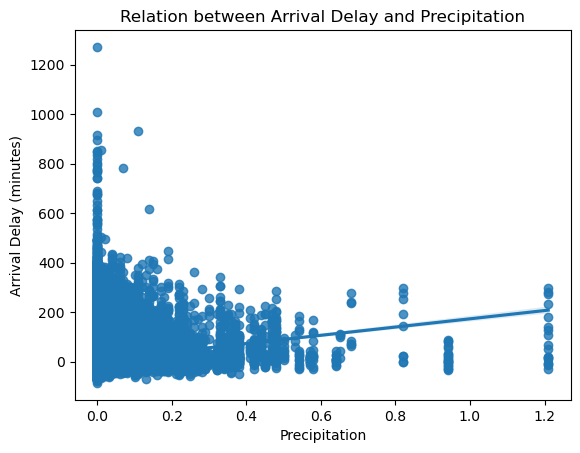

In [326]:
import seaborn as sns

# Example data
# Create the scatter plot
sns.regplot(x=df['precip'], y=df['arr_delay'])

# Add labels and title
plt.xlabel('Precipitation')
plt.ylabel('Arrival Delay (minutes)')
plt.title('Relation between Arrival Delay and Precipitation')

# Display the plot
plt.show()

In [327]:

# correlation, p_value = pearsonr(df['precip'], df['arr_delay'])

# # Print the correlation coefficient and p-value
# print("Pearson Correlation Coefficient:", correlation)
# print("P-value:", p_value)

In [328]:
df=df.drop(['carrier','flight','alt','wind_dir','tailnum','manufacturer','minute','type','Dept_delay?','engine','origin','day','Day','dest','model','seats','engines','time_hour_x','date','time_hour_y','year_y','year','faa','name','tz','tzone'],axis=1)

In [329]:
df.columns

Index(['month', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time',
       'sched_arr_time', 'arr_delay', 'air_time', 'distance', 'hour',
       'Arr_delay?', 'time_of_day', 'season', 'weekend', 'temp', 'dewp',
       'humid', 'wind_speed', 'precip', 'pressure', 'visib', 'lat', 'lon'],
      dtype='object')

In [330]:
df.dropna(inplace = True)


#### Correlation check

In [331]:
# creating a list of numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()


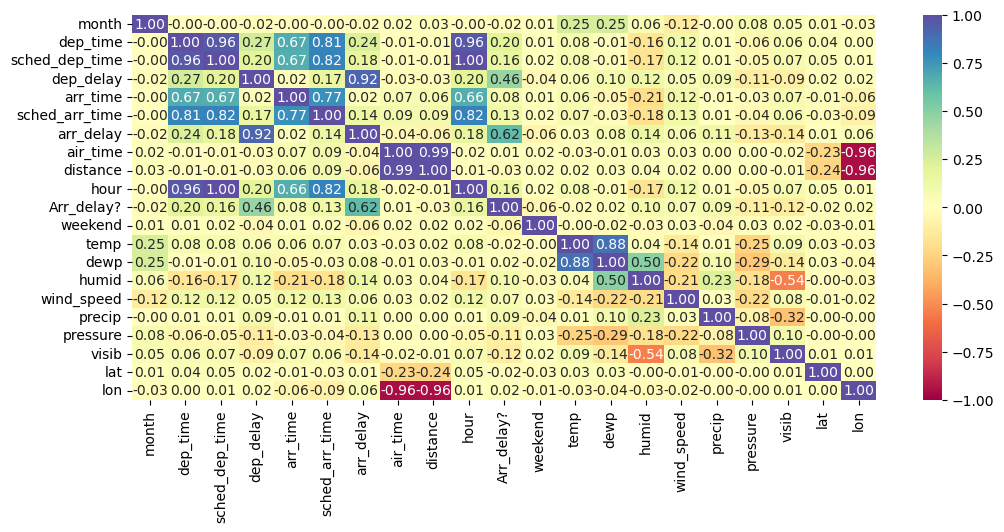

In [332]:
# Correlation check
plt.figure(figsize=(12, 5))
sns.heatmap(
    df[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

In [333]:
df=df.drop(['air_time','arr_delay','lon','hour','humid','dep_time','dewp','sched_dep_time'],axis=1)

In [334]:
df.shape

(272249, 15)

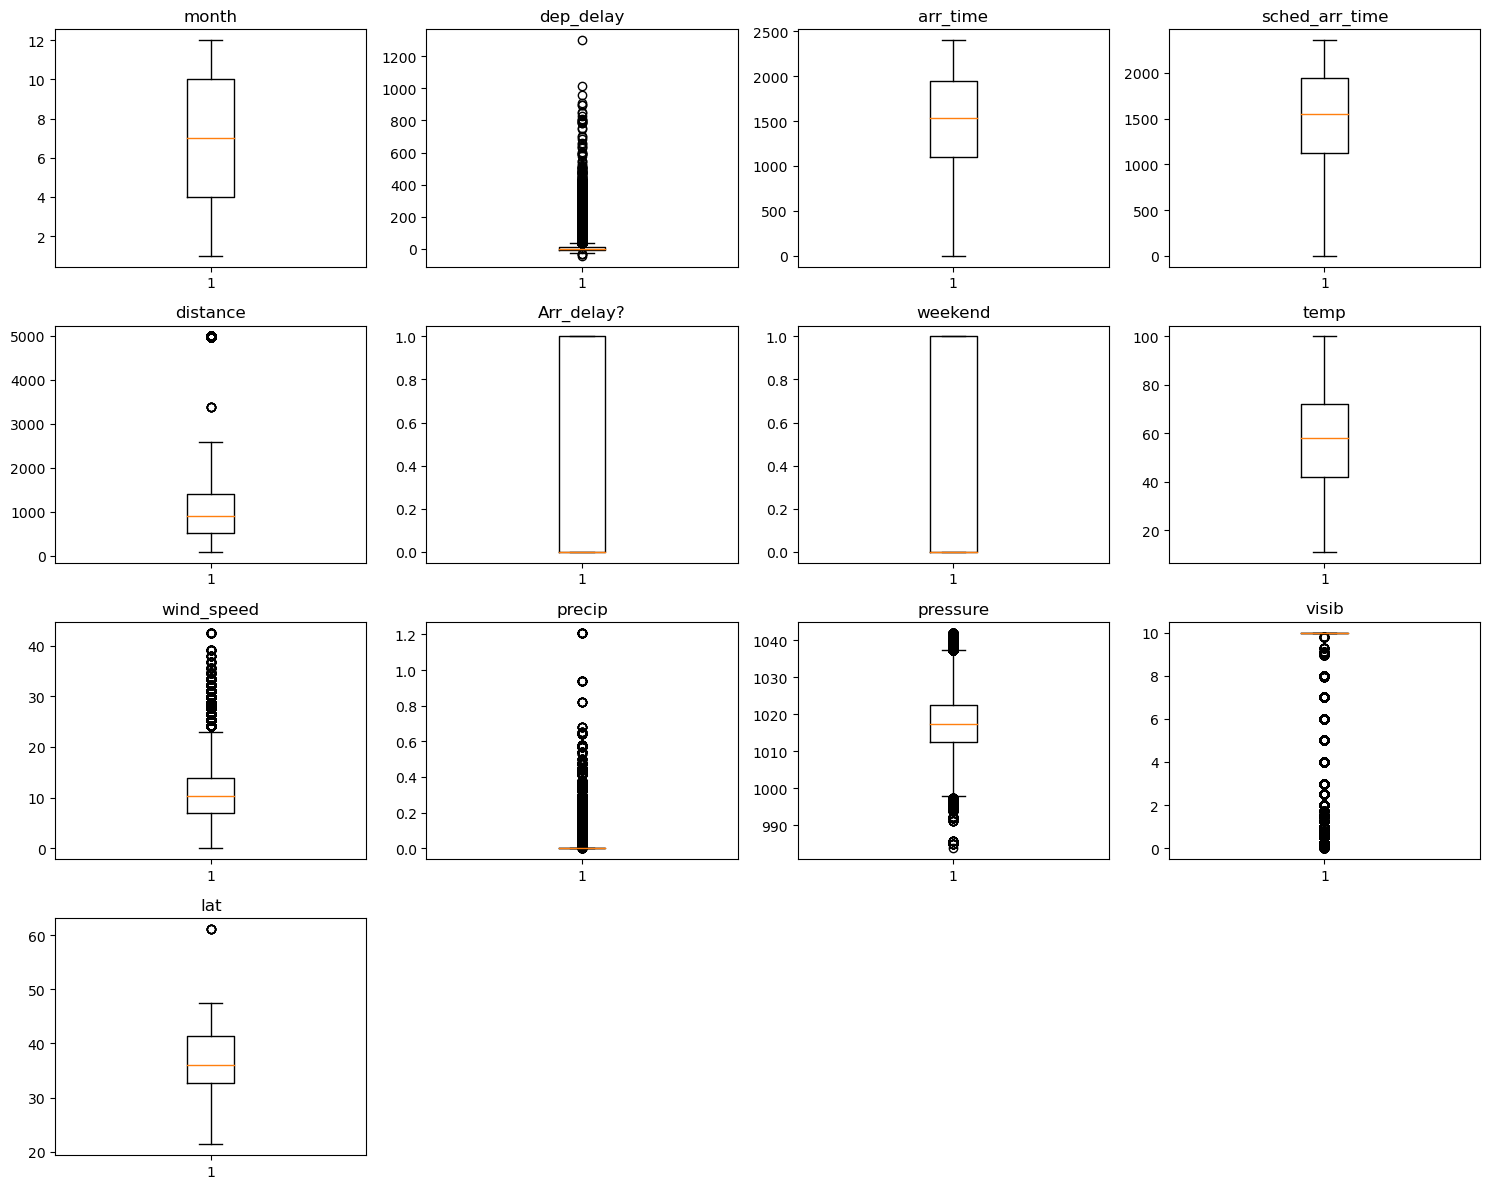

In [335]:
# # Outlier detection
# # Checking Outliers
# # Outlier detection
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()


plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [336]:
#Remove outliers
from scipy import stats
import numpy as np

# calculate the Interquartile Range (IQR)
Q1 = df['wind_speed'].quantile(0.25)
Q3 = df['wind_speed'].quantile(0.75)
IQR = Q3 - Q1

# remove outliers from the dataframe
df = df[~((df['wind_speed'] < (Q1 - 1.5 * IQR)) | (df['wind_speed'] > (Q3 + 1.5 * IQR)))]
#remove outliers from pressure column
Q1 = df['pressure'].quantile(0.25)
Q3 = df['pressure'].quantile(0.75)
IQR = Q3 - Q1

# remove outliers from the dataframe
df = df[~((df['pressure'] < (Q1 - 1.5 * IQR)) | (df['pressure'] > (Q3 + 1.5 * IQR)))]


In [337]:
df.columns

Index(['month', 'dep_delay', 'arr_time', 'sched_arr_time', 'distance',
       'Arr_delay?', 'time_of_day', 'season', 'weekend', 'temp', 'wind_speed',
       'precip', 'pressure', 'visib', 'lat'],
      dtype='object')

In [338]:
# X.columns

##### Modelling

#### Logistic Regression

In [339]:

X = df.drop(["Arr_delay?"], axis=1)
Y = df["Arr_delay?"]

# adding constant
X = sm.add_constant(X)

X = pd.get_dummies(X, drop_first=True)



In [340]:
X.head()
# X['manufacturer_airbus'] = X['manufacturer_airbus'].astype(int)  
# X['manufacturer_boeing'] = X['manufacturer_boeing'].astype(int) 
# X['manufacturer_bombardier inc'] = X['manufacturer_bombardier inc'].astype(int) 
# X['manufacturer_embraer'] = X['manufacturer_embraer'].astype(int) 
# X['manufacturer_mcdonnell douglas'] = X['manufacturer_mcdonnell douglas'].astype(int) 
X['season_Spring'] = X['season_Spring'].astype(int) 
X['season_Summer'] = X['season_Summer'].astype(int) 
X['season_Winter'] = X['season_Winter'].astype(int) 
X['time_of_day_Eve'] = X['time_of_day_Eve'].astype(int) 
X['time_of_day_Morning'] = X['time_of_day_Morning'].astype(int) 
X['time_of_day_Night'] = X['time_of_day_Night'].astype(int)
X['time_of_day_Noon'] = X['time_of_day_Noon'].astype(int)

In [341]:
# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)

In [342]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (184902, 20)
Shape of test set :  (79244, 20)
Percentage of classes in training set:
Arr_delay?
0    0.596094
1    0.403906
Name: proportion, dtype: float64
Percentage of classes in test set:
Arr_delay?
0    0.597458
1    0.402542
Name: proportion, dtype: float64


In [343]:
# fitting logistic regression model
logit = sm.Logit(y_train, X_train.astype(float))
lg = logit.fit(disp=False)

print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:             Arr_delay?   No. Observations:               184902
Model:                          Logit   Df Residuals:                   184882
Method:                           MLE   Df Model:                           19
Date:                Tue, 04 Jul 2023   Pseudo R-squ.:                  0.3483
Time:                        04:39:02   Log-Likelihood:                -81287.
converged:                       True   LL-Null:                   -1.2473e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  20.0701      0.963     20.831      0.000      18.182      21.958
month                   0.0294      0.002     12.557      0.000       0.025       0.034
dep_delay       

In [344]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf


In [345]:
# defining a function to plot the confusion_matrix of a classification model


def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [346]:
print("Training performance:")
model_performance_classification_statsmodels(lg, X_train, y_train)

Training performance:


,Accuracy,Recall,Precision,F1
0,0.801479,0.609094,0.858251,0.712519


#### Multicollinearity

In [347]:
# we will define a function to check VIF
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif

In [348]:
checking_vif(X_train)

,feature,VIF
0,const,24485.808517
1,month,1.819183
2,dep_delay,1.124501
3,arr_time,2.737055
4,sched_arr_time,4.518574
5,distance,1.090265
6,weekend,1.008180
7,temp,3.254205
8,wind_speed,1.163940
9,precip,1.140047


##### Decision tree

In [349]:

X = df.drop(["Arr_delay?"], axis=1)
Y = df["Arr_delay?"]
X = pd.get_dummies(X, drop_first=True)
# X['manufacturer_airbus'] = X['manufacturer_airbus'].astype(int)  
# X['manufacturer_boeing'] = X['manufacturer_boeing'].astype(int) 
# X['manufacturer_bombardier inc'] = X['manufacturer_bombardier inc'].astype(int) 
# X['manufacturer_embraer'] = X['manufacturer_embraer'].astype(int) 
# X['manufacturer_mcdonnell douglas'] = X['manufacturer_mcdonnell douglas'].astype(int) 
X['season_Spring'] = X['season_Spring'].astype(int) 
X['season_Summer'] = X['season_Summer'].astype(int) 
X['season_Winter'] = X['season_Winter'].astype(int) 
X['time_of_day_Eve'] = X['time_of_day_Eve'].astype(int) 
X['time_of_day_Morning'] = X['time_of_day_Morning'].astype(int) 
X['time_of_day_Night'] = X['time_of_day_Night'].astype(int)
X['time_of_day_Noon'] = X['time_of_day_Noon'].astype(int)

In [353]:
# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25,stratify=Y
)

In [354]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (198109, 19)
Shape of test set :  (66037, 19)
Percentage of classes in training set:
Arr_delay?
0    0.596505
1    0.403495
Name: proportion, dtype: float64
Percentage of classes in test set:
Arr_delay?
0    0.596499
1    0.403501
Name: proportion, dtype: float64


In [355]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(2, 7, 2),
    "max_leaf_nodes": [50, 75, 150, 250],
    "min_samples_split": [10, 30, 50, 70],
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=50,
                       min_samples_split=10, random_state=1)

In [356]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [357]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

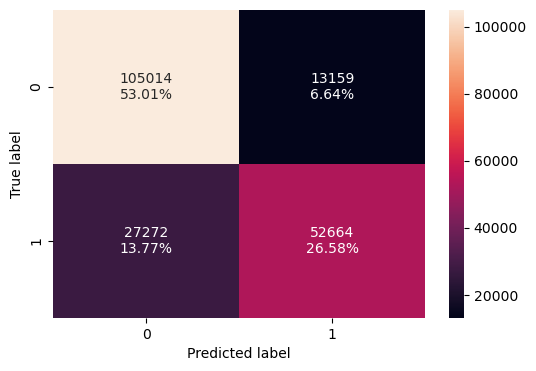

In [358]:
confusion_matrix_sklearn(estimator, X_train, y_train)

In [359]:
decision_tree_perf_train = model_performance_classification_sklearn(
    estimator, X_train, y_train
)
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,0.795915,0.658827,0.800085,0.722617


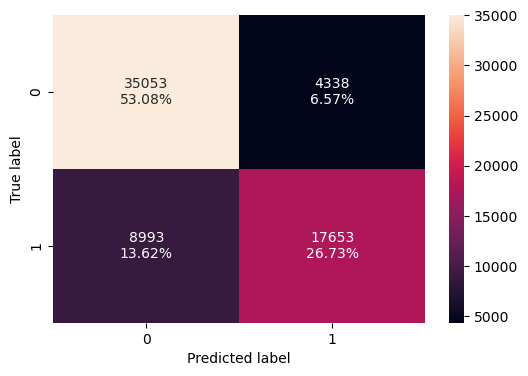

In [360]:
confusion_matrix_sklearn(estimator, X_test, y_test)

In [361]:
decision_tree_perf_test = model_performance_classification_sklearn(
    estimator, X_test, y_test
)
print("Model's Performance on Test")
decision_tree_perf_test

Model's Performance on Test


,Accuracy,Recall,Precision,F1
0,0.798128,0.662501,0.802737,0.725908


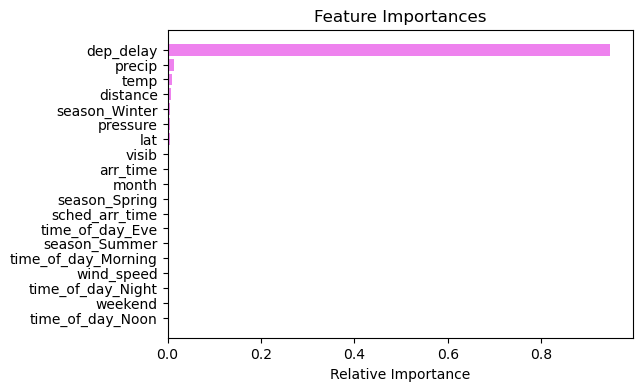

In [362]:
feature_names = list(X_train.columns)
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6, 4))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

#### Visualising Decision Tree

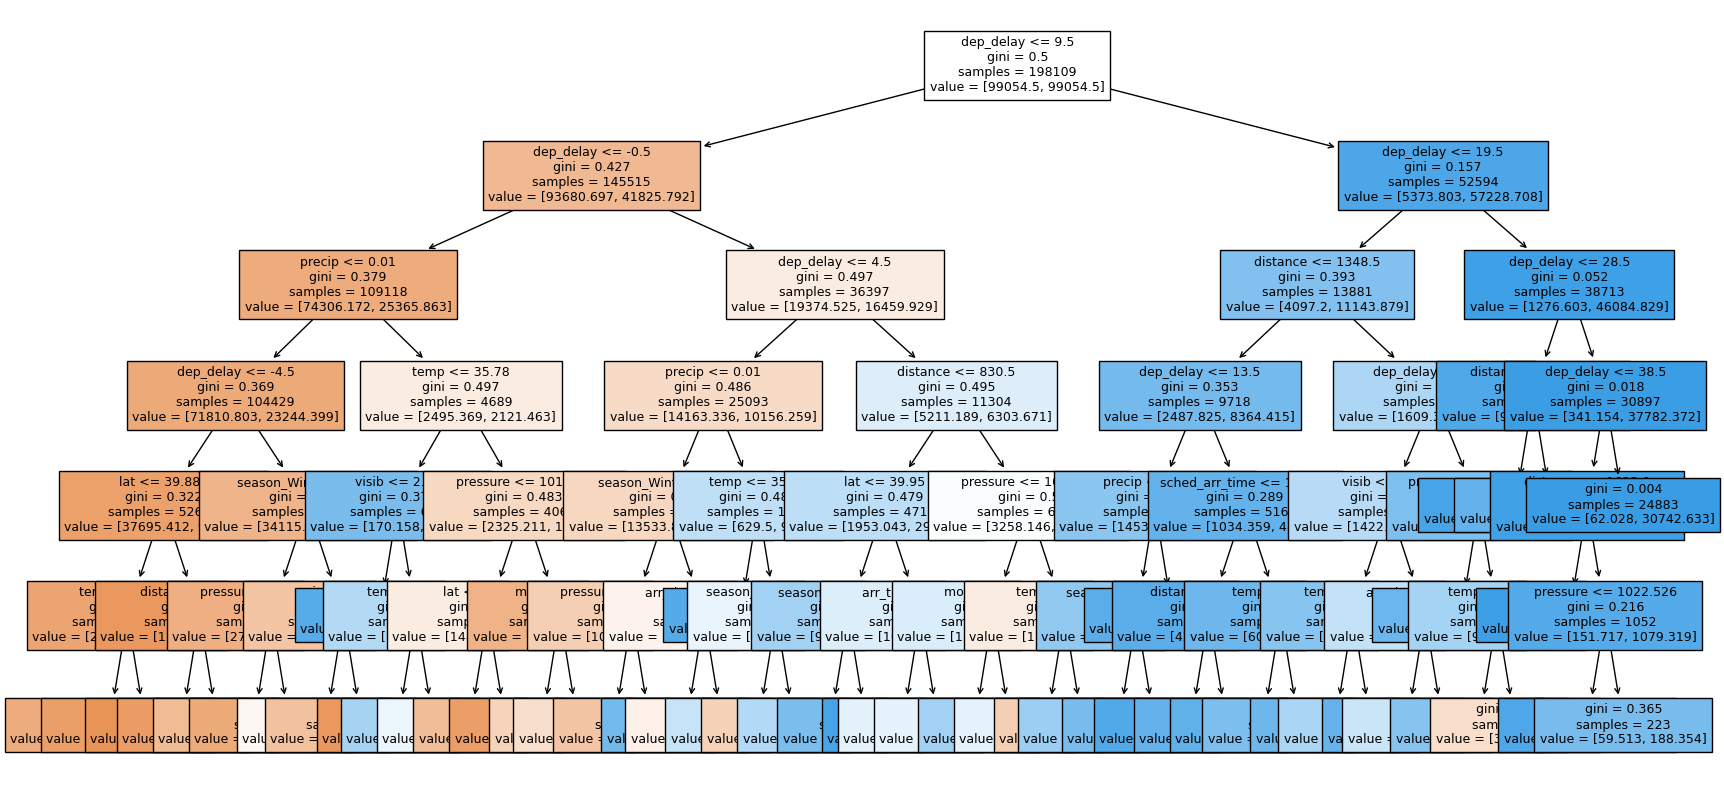

In [363]:
plt.figure(figsize=(20, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [364]:
# Text report showing the rules of a decision tree -
print(tree.export_text(estimator, feature_names=feature_names, show_weights=True))

|--- dep_delay <= 9.50
|   |--- dep_delay <= -0.50
|   |   |--- precip <= 0.01
|   |   |   |--- dep_delay <= -4.50
|   |   |   |   |--- lat <= 39.89
|   |   |   |   |   |--- temp <= 57.11
|   |   |   |   |   |   |--- weights: [12296.63, 4169.82] class: 0
|   |   |   |   |   |--- temp >  57.11
|   |   |   |   |   |   |--- weights: [12638.62, 3000.04] class: 0
|   |   |   |   |--- lat >  39.89
|   |   |   |   |   |--- distance <= 471.00
|   |   |   |   |   |   |--- weights: [7015.03, 1066.93] class: 0
|   |   |   |   |   |--- distance >  471.00
|   |   |   |   |   |   |--- weights: [5745.13, 1276.35] class: 0
|   |   |   |--- dep_delay >  -4.50
|   |   |   |   |--- season_Winter <= 0.50
|   |   |   |   |   |--- pressure <= 1013.90
|   |   |   |   |   |   |--- weights: [7455.09, 3439.94] class: 0
|   |   |   |   |   |--- pressure >  1013.90
|   |   |   |   |   |   |--- weights: [19664.55, 6499.46] class: 0
|   |   |   |   |--- season_Winter >  0.50
|   |   |   |   |   |--- visib <= 6.50
|

Decision Tree findings:


##### Random Forest

In [365]:
# Choose the type of classifier.
rf_tuned = RandomForestClassifier(random_state=1, oob_score=True, bootstrap=True)

parameters = {
    "max_depth": list(np.arange(5, 15, 5)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [3, 5, 7],
    "n_estimators": np.arange(10, 40, 10),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=acc_scorer, cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_tuned.fit(X_train, y_train)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=10,
                       oob_score=True, random_state=1)

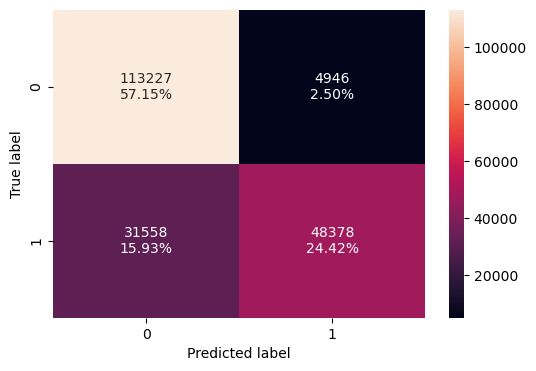

In [366]:
confusion_matrix_sklearn(rf_tuned, X_train, y_train)

In [367]:
rf_perf_train = model_performance_classification_sklearn(
    rf_tuned, X_train, y_train
)
rf_perf_train

,Accuracy,Recall,Precision,F1
0,0.815738,0.605209,0.907246,0.726069


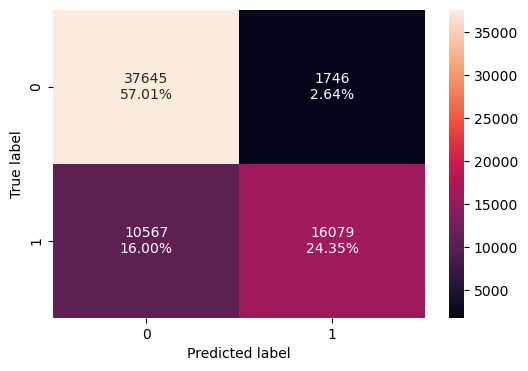

In [368]:
confusion_matrix_sklearn(rf_tuned, X_test, y_test)

In [369]:
rf_perf_test = model_performance_classification_sklearn(
    rf_tuned, X_test, y_test
)
rf_perf_test

,Accuracy,Recall,Precision,F1
0,0.813544,0.60343,0.902048,0.723123


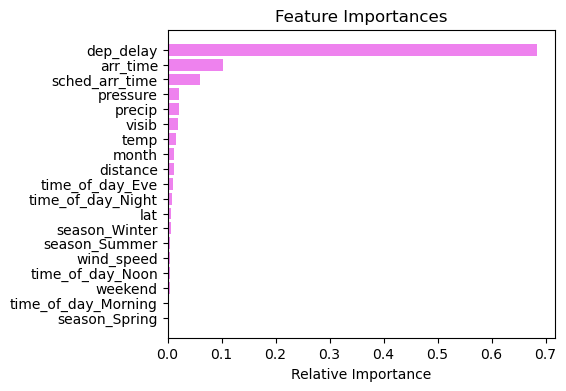

In [370]:
feature_names = X_train.columns
importances = rf_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(5,4))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [371]:
import shap
# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(rf_tuned)

# rf_shap_values = shap.KernelExplainer(estimator.predict,X_test)

In [381]:
X_test[X_test['month']>=6].head(20)

,month,dep_delay,arr_time,sched_arr_time,distance,weekend,temp,wind_speed,precip,pressure,visib,lat,time_of_day_Eve,time_of_day_Morning,time_of_day_Night,time_of_day_Noon,season_Spring,season_Summer,season_Winter
89571,10,-2.0,1826.0,1818,760,1,62.06,6.90468,0.00,1011.500000,10.0,33.636719,0,0,0,1,0,0,0
29502,10,-6.0,1248.0,1322,1400,1,66.92,4.60312,0.00,1017.766667,7.0,29.984433,0,1,0,0,0,0,0
210141,12,-4.0,2356.0,2355,2454,0,41.00,5.75390,0.00,1013.600000,9.0,45.588722,1,0,0,0,0,0,1
143035,10,-4.0,1401.0,1425,1620,0,50.00,16.11092,0.00,1020.200000,10.0,39.861656,0,1,0,0,0,0,0
225438,10,1.0,2032.0,2045,229,1,53.06,11.50780,0.00,1013.900000,10.0,38.944533,1,0,0,0,0,0,0
70023,8,-2.0,1340.0,1358,746,0,78.08,6.90468,0.00,1015.015789,10.0,33.636719,0,1,0,0,0,1,0
16481,9,-1.0,2020.0,2037,2565,0,64.04,11.50780,0.00,1015.400000,10.0,37.618972,1,0,0,0,0,0,0
212828,7,-4.0,1606.0,1625,1065,0,89.06,11.50780,0.00,1016.300000,10.0,26.072583,0,0,0,1,0,1,0
114260,7,92.0,931.0,810,569,0,75.02,5.75390,0.00,1017.900000,9.0,39.048836,0,0,0,0,0,1,0
178549,10,0.0,1428.0,1431,1047,0,60.08,20.71404,0.00,1028.900000,10.0,27.395444,0,1,0,0,0,0,0


In [376]:
# X_train.loc[172843]

In [377]:
# Calculate Shap values
choosen_instance = X_test.loc[[165689]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [380]:
# Calculate Shap values
choosen_instance = X_test.loc[[45258]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [385]:
choosen_instance = X_test.loc[[96647]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

TypeError: only integer scalar arrays can be converted to a scalar index

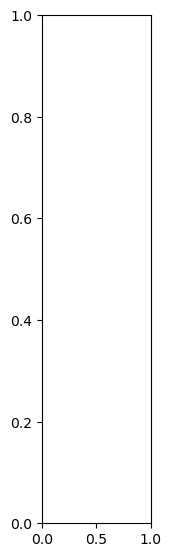

In [388]:
import shap 
explainer = shap.TreeExplainer(rf_tuned)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)